In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Utility Functions

In [3]:
def createAnimation(gridHist, filename='diffusion_simulation', format='gif'):
    """
    Create and save a gif of the grid evolution, showing the step number on each frame.

    Args:
    gridHist (ndarray): 3D array of grid states over time
    filename (str): Name of the output gif file
    format (str): Format of the output file (only 'gif' is supported)
    """
    fig, ax = plt.subplots()
    ims = []
    for t, grid in enumerate(gridHist):
        im = ax.imshow(grid, cmap='viridis', animated=True)
        text = ax.text(0.02, 0.95, f'Step: {t}', transform=ax.transAxes, color='white',
                       fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
        ims.append([im, text])

    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat_delay=1000)
    ani.save(f'{filename}.gif', writer='pillow')

    plt.close()

In [4]:
def simSnapshot(grid, step, filename='diffusion_snapshot'):
    """
    Create and show a snapshot of the grid at a specific step.

    Args:
    grid (ndarray): 2D array representing the grid state
    step (int): The current step number
    filename (str): Name of the output image file
    """
    fig, ax = plt.subplots()
    im = ax.imshow(grid, cmap='viridis')
    plt.colorbar(im)
    ax.text(0.02, 0.95, f'Step: {step}', transform=ax.transAxes, color='white',
            fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
    # Just showing the plot
    plt.show()

### Automata Functions

In [5]:
def getNeighbors(x, y, M, N, rad):
    """
    Get the neighbors of a cell within a given radius.

    Args:
    x, y (int): Cell coordinates
    M, N (int): Grid dimensions
    rad (int): Radius for neighborhood

    Returns:
    neighbors (ndarray): Array of neighbor coordinates
    """
    neighbors = []
    for i in range(-rad, rad + 1):
        for j in range(-rad, rad + 1):
            if i == 0 and j == 0:
                continue  # Skip the current cell itself
            if 0 <= x + i < M and 0 <= y + j < N:  # Ensure within grid bounds
                neighbors.append([x + i, y + j])

    return np.array(neighbors)  # Convert to NumPy array for efficiency

In [6]:
def automatonStep(u_0, K, M, N, rad, mask):
    """
    Perform a single step of the diffusion process.

    Args:
    u_0 (ndarray): Current state of the grid
    K (float): Diffusion coefficient
    M, N (int): Grid dimensions
    rad (int): Radius for neighborhood
    mask (ndarray): Mask for the grid

    Returns:
    u_new (ndarray): Updated grid
    """
    u_new = u_0.copy()  # Copy the current grid to avoid modifying it in place

    # Loop over each cell in the grid
    for x in range(M):
        for y in range(N):
            if mask[x, y]:  # Only update cells inside the masked region
                neighbors = getNeighbors(x, y, M, N, rad)  # Get the neighbors
                valid_neighbors = mask[neighbors[:, 0], neighbors[:, 1]]  # Check which neighbors are in the mask
                neighbor_values = u_0[neighbors[:, 0], neighbors[:, 1]]
                neighbor_sum = np.sum(neighbor_values[valid_neighbors])
                num_valid_neighbors = np.sum(valid_neighbors)
                if num_valid_neighbors > 0:
                    u_new[x, y] = (1 - K) * u_0[x, y] + (K / num_valid_neighbors) * neighbor_sum

    return u_new

In [7]:
def automatonSim(M, N, T, u_0, K, rad, mask):
    """
    Simulate the diffusion process using a cellular automaton.

    Args:
    M, N (int): Grid dimensions
    T (int): Number of time steps
    u_0 (ndarray): Initial distribution (2D array of size M x N)
    K (float): Diffusion rate parameter
    rad (int): Radius for neighborhood
    mask (ndarray): Boolean mask defining the diffusion region (True for active cells)

    Returns:
    history (ndarray): 3D array with the system's evolution
    """
    u = u_0.copy()
    history = np.zeros((T+1, M, N))
    history[0] = u

    for t in range(T):
        u = automatonStep(u, K, M, N, rad, mask)
        history[t+1] = u

    return history

#### Testing

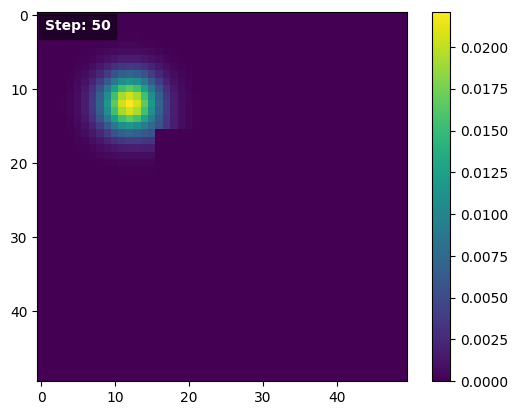

In [8]:
M, N = 50, 50
T = 100
K = 0.2
rad = 1

mask = np.ones((M, N), dtype=bool)
mask[M//3:, N//3:] = False

u_0 = np.zeros((M, N))
u_0[M//4, N//4] = 1.0

history = automatonSim(M, N, T, u_0, K, rad, mask)

createAnimation(history, filename='diffusion_simulation')
simSnapshot(history[50], 50, filename='diffusion_snapshot')

### Particles Functions

In [9]:
def particleSim(M, N, T, u0, mask, Np):
    """
    Simulates the diffusion process using particles.

    Args:
    M, N (int): Grid dimensions.
    T (int): Number of time steps.
    u0 (ndarray): Initial distribution (2D array of size M x N).
    mask (ndarray): Boolean mask defining the diffusion region (True for active cells).
    Np (int): Number of particles to simulate.

    Returns:
    history (ndarray): 3D array with the system evolution (particle count in each cell).
    """
    # Initialize particles according to u0
    u0_flat = u0.flatten()
    mask_flat = mask.flatten()
    u0_flat = u0_flat * mask_flat  # Ensure u0 is zero outside the mask
    u0_flat = u0_flat / u0_flat.sum()  # Normalize to sum to 1

    indices = np.arange(M * N)
    initial_positions = np.random.choice(indices, size=Np, p=u0_flat)
    particle_positions = np.column_stack(np.unravel_index(initial_positions, (M, N)))

    history = np.zeros((T + 1, M, N), dtype=int)
    np.add.at(history[0], (particle_positions[:, 0], particle_positions[:, 1]), 1)

    # Possible displacements towards neighbors
    neighbor_offsets = np.array([
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),          (0, 1),
        (1, -1),  (1, 0),  (1, 1)
    ])

    for t in range(1, T + 1):
        # Select random movements for all particles
        movement_indices = np.random.choice(len(neighbor_offsets), size=particle_positions.shape[0])
        movements = neighbor_offsets[movement_indices]
        # Update positions
        new_positions = particle_positions + movements
        # Ensure particles remain within boundaries
        new_positions[:, 0] = np.clip(new_positions[:, 0], 0, M - 1)
        new_positions[:, 1] = np.clip(new_positions[:, 1], 0, N - 1)
        # Check which particles move to valid cells
        valid_mask = mask[new_positions[:, 0], new_positions[:, 1]]
        # For particles that don't move to valid cells, they remain in their current position
        new_positions[~valid_mask] = particle_positions[~valid_mask]
        # Update particle positions
        particle_positions = new_positions
        # Record positions in history
        np.add.at(history[t], (particle_positions[:, 0], particle_positions[:, 1]), 1)

    # Normalize history to obtain densities
    history = history / Np
    return history

#### Testing

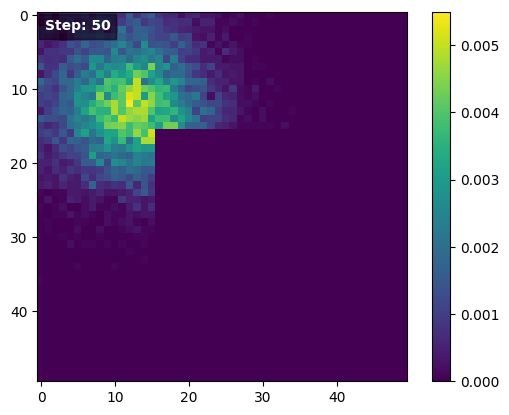

In [10]:
# Parámetros de la simulación
M, N = 50, 50
T = 100
Np = 10000  # Número de partículas

mask = np.ones((M, N), dtype=bool)
mask[M//3:, N//3:] = False

u_0 = np.zeros((M, N))
u_0[M//4, N//4] = 1.0

# Ejecutar la simulación de partículas
history_particles = particleSim(M, N, T, u_0, mask, Np)

# Crear animación y snapshot
createAnimation(history_particles, filename='diffusion_particle_simulation')
simSnapshot(history_particles[50], 50, filename='diffusion_particle_snapshot')